<a href="https://colab.research.google.com/github/LongS1eeper/ML-DL_Prac/blob/%ED%98%BC%EA%B3%B5/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0_09_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## IMDB 리뷰 데이터셋

In [ ]:
# 리뷰 데이터 셋 : imdb
# 훈련 세트와 테스트 세트 각각 25000개씩 존재
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200)

In [ ]:
# 리뷰가 넘파이 배열에 한칸씩 할당되어있음
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [ ]:
# 첫번째 리뷰의 길이
print(len(train_input[0]))

218


In [ ]:
print(len(train_input[1]))

189


In [ ]:
# 공백을 기준으로 단어를 정수로 변환한 상태
# 어휘사전에 없는 단어는 2로 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
# 0은 부정, 1은 긍정
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [ ]:
from sklearn.model_selection import train_test_split

# 훈련세트와 검증세트 분리
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
# 평균리뷰 길이, 가장 짧은 리뷰 길이, 가장 긴 리뷰 길이 확인하고 싶음
import numpy as np

lengths = np.array([len(x) for x in train_input]) # lengths라는 넘파이배열에 모든 리뷰 길이 추가

In [ ]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


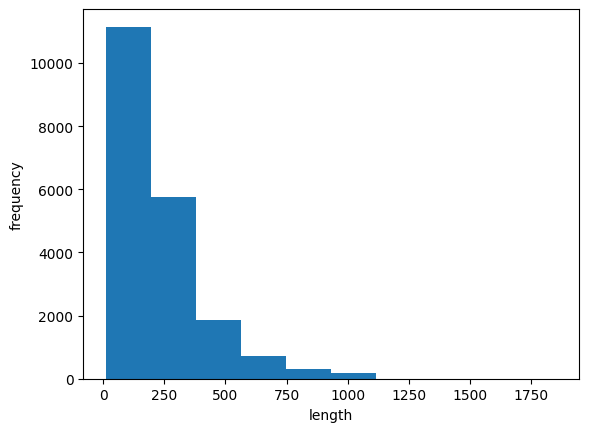

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [ ]:
# 리뷰는 대부분 짧아서 100개의 단어만 사용할 예정
# 100개보다 작은 단어를 가진 리뷰는 길이를 100에 맞추기 위해 0으로 패딩
#-> pad_sequence (특정 수, 100) 넘파이 배열로 맞추기 위해
# 주로 앞부분을 자름 -> 뒷부분 내용이 더 의미있을 것이라 생각 (truncating 매개변수를 post로 바꾸면 뒤가 날라감)
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [ ]:
print(train_seq.shape)

(20000, 100)


In [ ]:
print(train_seq[0]) # 딱 100개 이므로 train_seq에서 조작되지 않음

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [ ]:
# 위에 배열 중 마지막 줄만 가져옴 -> 조작이 되었는지 확인 위해
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [ ]:
# 길이가 100보다 짧아서 0으로 채워짐
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [ ]:
# 검증세트의 길이도 조작
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

In [ ]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 정수 배열을 입력하면 자동으로 원-핫 인코딩된 배열을 반환해줌
train_oh = keras.utils.to_categorical(train_seq)

In [ ]:
print(train_oh.shape)

(20000, 100, 200)


In [ ]:
# 첫번쨰 토큰인 10이 잘 인코딩 됨
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
# 모든 원소를 더했을때 1임 -> 1개만 원핫 인코딩에 의해 1이 됨
print(np.sum(train_oh[0][0]))

1.0


In [ ]:
# 검증세트도 모두 조작 중
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

## 순환 신경망 훈련하기

In [ ]:
# 기본 RMSprop의 학습률 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 생성
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.4945 - loss: 0.7135 - val_accuracy: 0.4924 - val_loss: 0.7053
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5020 - loss: 0.7038 - val_accuracy: 0.4960 - val_loss: 0.7010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5059 - loss: 0.6993 - val_accuracy: 0.4962 - val_loss: 0.6984
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5124 - loss: 0.6964 - val_accuracy: 0.5038 - val_loss: 0.6962
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5154 - loss: 0.6943 - val_accuracy: 0.5110 - val_loss: 0.6939
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5195 - loss: 0.6925 - val_accuracy: 0.5120 - val_loss: 0.6925
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.5228 - loss: 0.6915 - val_accuracy: 0.5162 - val_loss: 0.6917
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5255 - loss: 0.

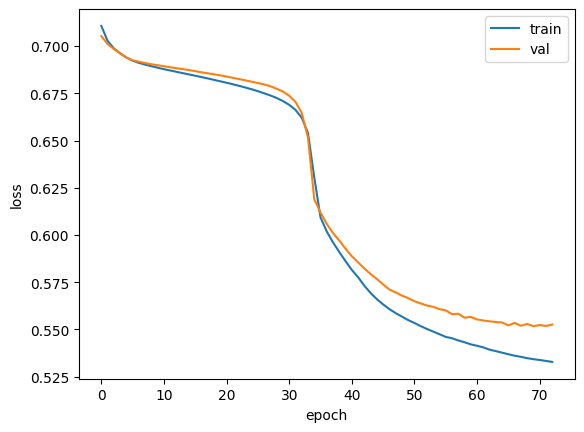

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기
단어 임베딩은 “단어”라는 이산 토큰을 실수 벡터로 매핑하여,
의미적 관계를 학습 가능한 형태로 압축·표현하는 핵심 기술입니다.

**단어 임베딩의 ‘거리’**는

의미가 얼마나 비슷한지를 재는 잣대이고,

훈련 중에 “의미가 비슷한 단어”들이 서로 가까워지도록 벡터를 조정하는 과정이에요.

그래서 “단어 간 거리 = 의미적 유사도”라고 이해하시면 됩니다.

In [ ]:
# 이전 방식은 입력 데이터를 원-핫 인코딩으로 변환하여 데이터가 엄청 커졌음
# 그래서 단어 임베딩이라는 기능을 통해 0과 1이 아닌 실수 벡터로 변환
model2 = keras.Sequential()

# 200 : 어휘사전 크기, 16 : 임베딩 벡터의 크기, 100 : 샘플의 길이
model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))  # 단어 임베딩 벡터를 만드는 층.
model2.add(keras.layers.SimpleRNN(8))  # 16*8 + 8*8 + 8 = 200
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5026 - loss: 0.6955 - val_accuracy: 0.4980 - val_loss: 0.6949
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5176 - loss: 0.6925 - val_accuracy: 0.5036 - val_loss: 0.6939
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5347 - loss: 0.6903 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5454 - loss: 0.6884 - val_accuracy: 0.5122 - val_loss: 0.6926
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5567 - loss: 0.6864 - val_accuracy: 0.5180 - val_loss: 0.6921
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5663 - loss: 0.6844 - val_accuracy: 0.5218 - val_loss: 0.6917
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5724 - loss: 0.6825 - val_accuracy: 0.5234 - val_loss: 0.6914
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5744 - loss: 0.68

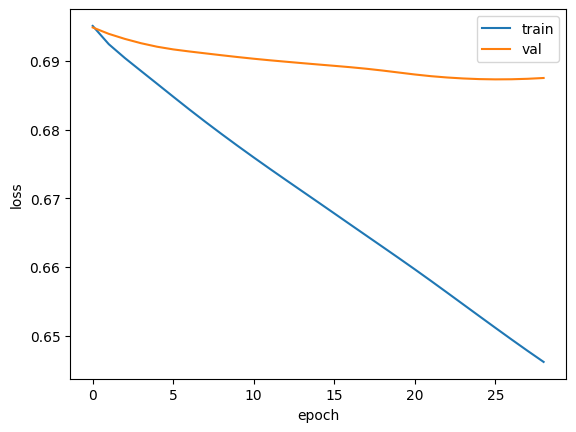

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()